When we use the vector spherical harmonics (VSH) technique to analyze the sysmatics or global feature of catalogs, the all-sky distribution of radio sources (quasars) could be of great care since it would cause a strong correlation between parameters.

The first thing to do always is to import some required packages

In [1]:
from astropy.table import Table, Column
from astropy import units as u
from astropy.coordinates import SkyCoord, ICRS, Galactic
from astropy_healpix import HEALPix

import numpy as np
import sys

Then I load an auxiliary catalog `aux_allwise_agn_gdr2_cross_id`. This catalog is a cross-match result between AllWISE and Gaia DR2 catalog, providing the astrometric information for 555934 quasars.

In [24]:
table_qso = Table.read(
    "/Users/Neo/Astronomy/Data/catalogs/Gaia_DR2/gaiadr2_agn.fits")

table_qso.keep_columns(["source_id",
                        "ra",
                        "ra_error",
                        "dec",
                        "dec_error",
                        "parallax",
                        "parallax_error",
                        "pmra",
                        "pmra_error",
                        "pmdec",
                        "pmdec_error",
                        "ra_dec_corr",
                        "ra_parallax_corr",
                        "ra_pmra_corr",
                        "ra_pmdec_corr",
                        "dec_parallax_corr",
                        "dec_pmra_corr",
                        "dec_pmdec_corr",
                        "parallax_pmra_corr",
                        "parallax_pmdec_corr",
                        "pmra_pmdec_corr",
                        "phot_g_mean_mag",
                        "phot_bp_mean_mag",
                        "phot_rp_mean_mag"])

table_qso_name = Table(table_qso)
table_qso_name.keep_columns(["source_id"])

table_qso, table_qso_name

(<Table masked=True length=555934>
      source_id                ra           ... phot_bp_mean_mag phot_rp_mean_mag
                              deg           ...       mag              mag       
        int64               float64         ...     float32          float32     
 ------------------- ---------------------- ... ---------------- ----------------
 4990063158213472768 0.00026211313469895394 ...        18.615639         17.52736
 2875546163053982464  0.0006280500798165479 ...        18.798977        18.126667
 2341836729236155008  0.0006607258634349985 ...        18.012331         17.31885
 4635686437412067840  0.0010296260789968087 ...        20.818207        19.459929
 2305851255551067776  0.0014282617746582743 ...        18.795727        18.205362
 2747188660230483712  0.0019172973085235152 ...        18.520456        17.896278
 2420718231737082368  0.0030810817071089485 ...        20.124994        19.146517
 2341416058663072000   0.003456675397054641 ...         18.6515

Then I perform a healpixization on the catalog.

In [25]:
hp = HEALPix(nside=32, order="nested", frame=ICRS())
Nsize = hp.npix

print("The sky is divided into", Nsize, "zones with an equal area.")

The sky is divided into 12288 zones with an equal area.


In [26]:
coord = SkyCoord(ra=table_qso["ra"], dec=table_qso["dec"], frame="icrs")

# Index of zones which every source belongs to.
indx = hp.skycoord_to_healpix(coord) 
indx_col = Column(indx, name="hlp_index")
table_qso.add_column(indx_col)
table_qso_name.add_column(indx_col)

# Coordinates of every zones
indx_coord = hp.healpix_to_skycoord(np.arange(Nsize))

# For a Mollweide projection, the mid-point of the plot should be 0. 
# And the plot needs ra and dec to be in the unit of radian.
indx_ra_rad = indx_coord.ra.wrap_at(180*u.deg).radian
indx_dec_rad = indx_coord.dec.radian

I try to use the attribute `group_by` to count the soources in each cell.

In [27]:
table_qso_name1 = table_qso_name.group_by("hlp_index")
indx_nsou = table_qso_name1.groups.aggregate(len)["source_id"]
np.sum(indx_nsou), indx_nsou.size

(555934, 11132)

In [32]:
sou_sample = table_qso.group_by("hlp_index").groups.aggregate(np.random.choice)

source_id,ra,ra_error,dec,dec_error,parallax,parallax_error,pmra,pmra_error,pmdec,pmdec_error,ra_dec_corr,ra_parallax_corr,ra_pmra_corr,ra_pmdec_corr,dec_parallax_corr,dec_pmra_corr,dec_pmdec_corr,parallax_pmra_corr,parallax_pmdec_corr,pmra_pmdec_corr,phot_g_mean_mag,phot_bp_mean_mag,phot_rp_mean_mag,hlp_index
,deg,mas,deg,mas,mas,mas,mas / yr,mas / yr,mas / yr,mas / yr,,,,,,,,,,,mag,mag,mag,
int64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,int64
449665896177408,44.27994007100387,0.6322106169498907,0.5437712864337338,1.3936901090174223,-0.2489227665895929,0.7508486672286298,-1.2453104274189366,0.8901569490122299,-0.5753380363277513,1.0376602638255379,0.17271815,0.17375508,0.0010491731,0.064808115,-0.16995044,-0.4499125,0.244614,-0.12369221,0.23770408,0.014438259,19.62606,18.65878,19.361788,0
593083444027008,47.11067747859288,0.29116652927646614,1.6545578768726115,0.18364793733777848,0.6716459976348632,1.3728557670719068,0.4525285401325243,0.9480725401226817,-0.6805758847504874,0.860282674570879,0.39423054,0.020736018,-0.3191847,-0.14999948,-0.5099864,0.08231774,-0.37106895,0.35837284,0.26872683,0.31903815,18.5121,20.053116,17.0548,1
1494098863344768,44.397954323541825,1.1556152651803933,3.380836018677437,0.5271396246179134,-0.044381038528350195,0.4454164339207996,-0.9089096725137957,0.946687163505137,-1.3123697664874607,0.3268906412002806,-0.033278283,0.21869765,0.036168627,0.17791879,-0.4246798,-0.03179982,0.23560049,0.22789861,0.5005638,0.45378,19.65444,20.25058,19.941946,2
1893496462316032,44.54456996430434,0.6316024714977311,4.174951933074202,0.7163004139043678,-0.03836915897799121,0.23157548269456416,1.0141131385884874,0.2957042641642934,3.078725234003472,0.4334340730280912,-0.044038467,0.056535333,-0.097248435,-0.12410444,-0.43488505,0.121746354,0.3394067,0.1833014,0.041221227,0.3684849,18.426964,18.345657,18.784813,3
2543548352281600,48.37623855678152,0.7935947320597767,4.256789911832332,0.3502966832197693,-0.8784741723492251,0.791927952812807,0.3934064451518853,0.695502309494389,0.9897638755774173,2.048437100513227,0.031827167,0.119448416,-0.031029806,0.15573414,-0.5966768,-0.06326586,-0.44812793,0.031161837,0.17373165,0.24749428,18.999214,19.617945,19.964115,4
3098183249196800,49.10010699083211,0.6267716741965965,4.841125531934956,0.3318304533482373,-0.03133212152917018,1.1147699628590786,-0.4895634679494738,1.0449347552450756,-1.7328164821349477,0.54236509351038,0.067414,0.37118715,-0.10426497,0.09266905,-0.46555156,0.2213363,0.64196825,0.22611046,-0.52989745,0.44296813,19.051702,18.120039,17.40336,5
3611655179341696,45.98466571472537,0.6184832526000277,4.00949231678643,0.8423802194808766,-1.285911004515213,0.43236124162303713,-0.43691931187508365,0.3102142607369132,-0.16825527094549153,0.4545645577534936,0.007094505,0.34690142,-0.056555185,0.09639931,-0.115274616,0.068846084,0.18970682,0.25770098,-0.49450567,0.6470149,20.442934,19.960299,19.638737,6
3967587709246720,48.1902656754041,1.0504991812509843,5.56141214221369,0.28995932395417173,1.832278193924878,0.6590694457408091,1.4444843910048069,0.7113625445142561,2.0481186442482286,0.7574116672107688,0.16292354,0.36094975,0.1479769,0.19507799,-0.23302442,-0.10906553,-0.14501978,-0.15896703,-0.17499992,0.2485095,18.588324,18.800774,18.734194,7


But the problem is that there are some zones without any source.
so I count the number of sources in each zone in a rather "stupid" and low-efficient way.
In the meanwhile, we randomly select one source to get a table of sources with nearly perfect distribution from each zone (with sources).

In [33]:
indx_nsou2 = np.zeros(Nsize)

for i in range(Nsize):
    sub_table = table_qso[indx==i]
    indx_nsou2[i] = len(sub_table)

The mean number of sources in each zone is 49.9401724757456 with a maximum of 143 and a minimum of 1
There are 0 zones without any sources.


In [35]:
print("The mean number of sources in each zone is", np.mean(indx_nsou2), 
      "with a maximum of", np.max(indx_nsou2), "and a minimum of", np.min(indx_nsou2))

zerosou = len(indx_nsou2[indx_nsou2==0])
print("There are", zerosou, "zones without any sources.")

The mean number of sources in each zone is 45.242024739583336 with a maximum of 143.0 and a minimum of 0.0
There are 1156 zones without any sources.


Plot the all-sky distribution of number of sources in each zone.

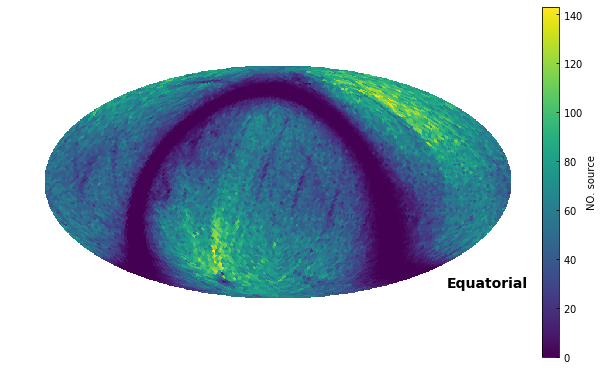

In [38]:
import healpy
import matplotlib.pyplot as plt

healpy.mollview(indx_nsou2, coord="C", nest=True, cbar=None, min=0, title="")

fig = plt.gcf()
ax = plt.gca()
image = ax.get_images()[0]
cmap = fig.colorbar(image, ax=ax, label="NO. source")
plt.savefig("../plots/qso_sample_dist_equ.eps")

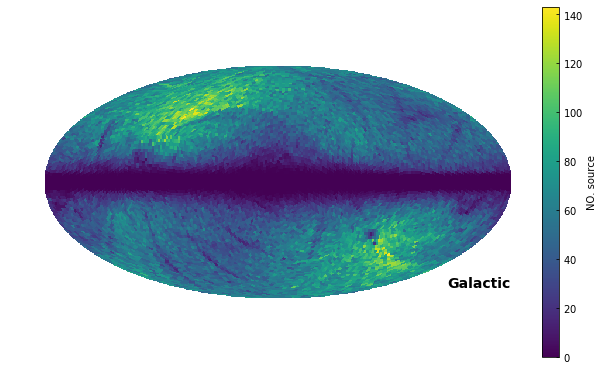

In [39]:
healpy.mollview(indx_nsou2, coord=["C", "G"], nest=True, cbar=None, min=0, title="")

fig = plt.gcf()
ax = plt.gca()
image = ax.get_images()[0]
cmap = fig.colorbar(image, ax=ax, label="NO. source")
plt.savefig("../plots/qso_sample_dist_gal.eps")

Then I perform a `lsq` fitting with VSH functions.

In [42]:
# My modules
from my_progs.catalog.vsh_deg1_cor import vsh_deg01_fitting
from my_progs.catalog.vsh_deg2_cor import vsh_deg02_fitting
from my_progs.catalog.write_output import print_vsh1_corr, print_vsh2_corr

In [47]:
# Transform columns into np.array
pmra = np.array(sou_sample["pmra"])
pmdec = np.array(sou_sample["pmdec"])
pmra_err = np.array(sou_sample["pmra_error"])
pmdec_err = np.array(sou_sample["pmdec_error"])
ra_rad = np.array(sou_sample["ra"].to(u.radian))
dec_rad = np.array(sou_sample["dec"].to(u.radian))
pmra_pmdec_corr = np.array(sou_sample["pmra_pmdec_corr"])
pmra_pmdec_cov = pmra_pmdec_corr * pmra_err * pmdec_err

In [48]:
# Transformation parameters
# l_max = 1
w1_all, sig1_all, corrcoef1_all, _, _, _ = vsh_deg01_fitting(
    pmra, pmdec, ra_rad, dec_rad, pmra_err, pmdec_err,
    cov=pmra_pmdec_cov, elim_flag="None")

# l_max = 2
w2_all, sig2_all, corrcoef2_all, _, _, _ = vsh_deg02_fitting(
    pmra, pmdec, ra_rad, dec_rad, pmra_err, pmdec_err,
    cov=pmra_pmdec_cov, elim_flag="None")

# mas -> uas
w1 = w1_all * 1.e3
sig1 = sig1_all * 1.e3
w2 = w2_all * 1.e3
sig2 = sig2_all * 1.e3

# Print results
print("Estimates (%6d sources)\n"
      "----------------------------------------------"
      "----------------------------------------------\n"
      "               Rotation [uas]                 "
      "                  Glide [uas]               \n"
      "               x             y             z"
      "               x             y             z\n"
      "----------------------------------------------"
      "----------------------------------------------\n"
      "l_max=1  %+4.0f +/- %3.0f  %+4.0f +/- %3.0f  %+4.0f +/- %3.0f  "
      "  %+4.0f +/- %3.0f  %+4.0f +/- %3.0f  %+4.0f +/- %3.0f\n"
      "l_max=2  %+4.0f +/- %3.0f  %+4.0f +/- %3.0f  %+4.0f +/- %3.0f  "
      "  %+4.0f +/- %3.0f  %+4.0f +/- %3.0f  %+4.0f +/- %3.0f\n"
      "----------------------------------------------"
      "----------------------------------------------\n" %
      (pmra.size, w1[3], sig1[3], w1[4], sig1[4], w1[5], sig1[5],
       w1[0], sig1[0], w1[1], sig1[1], w1[2], sig1[2],
       w2[3], sig2[3], w2[4], sig2[4], w2[5], sig2[5],
       w2[0], sig2[0], w2[1], sig2[1], w2[2], sig2[2]))

quad_names = Column(["ER22", "EI22", "ER21", "EI21", "E20",
                     "MR22", "MI22", "MR21", "MI21", "M20"])
t_quad = Table([quad_names, w2[6:], sig2[6:]], names=["Quadrupolar term", "Estimate", "Error"])
t_quad["Estimate"].format = "%5.0f"
t_quad["Error"].format = "%5.0f"
print(t_quad)

print("Correlation coefficient between parameters in 'l_max=1' fit")
print_vsh1_corr(corrcoef1_all, deci_digit=1, included_one=False)

print("Correlation coefficient between parameters in 'l_max=2' fit")
print_vsh2_corr(corrcoef2_all, deci_digit=1, included_one=False)

# apriori statistics (weighted)
#         mean for RA:     -0.000 mas
#         wrms for RA:      1.340 mas
#          std for RA:      1.340 mas
#        mean for Dec:      0.012 mas
#        wrms for Dec:      1.198 mas
#         std for Dec:      1.198 mas

# apriori reduced Chi-square for:      7.840
# posteriori statistics  of vsh01 fit (weighted)
#         mean for RA:     -0.018 mas
#          rms for RA:      1.341 mas
#          std for RA:      1.341 mas
#        mean for Dec:      0.022 mas
#         rms for Dec:      1.199 mas
#         std for Dec:      1.199 mas

# posteriori reduced Chi-square for:      7.825
# goodness-of-fit is      0.000
# apriori statistics (weighted)
#         mean for RA:     -0.000 mas
#         wrms for RA:      1.340 mas
#          std for RA:      1.340 mas
#        mean for Dec:      0.012 mas
#        wrms for Dec:      1.198 mas
#         std for Dec:      1.198 mas

# apriori reduced Chi-square for:      7.840
# posteriori statistics of vsh